In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
from transformers import BertForSequenceClassification,AdamW, BertConfig
import warnings
warnings.filterwarnings('ignore')
torch.cuda.is_available()

True

In [ ]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test_no_answer.csv')

# Preprocessing

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
import re
import string

def remove_punctuations(data):
  punct_tag=re.compile(r'[^\w\s]')
  data=punct_tag.sub(r'',data)
  return data

def lemma_traincorpus(data):
  lemmatizer=WordNetLemmatizer()
  out_data=""
  for words in data:
    out_data+= lemmatizer.lemmatize(words)
  return out_data


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
df_train_text=df_train['TEXT'].apply(lambda x: remove_punctuations(x))
df_train_text=df_train_text.apply(lambda x: lemma_traincorpus(x))
df_test_text=df_test['TEXT'].apply(lambda x: remove_punctuations(x))
df_test_text=df_test_text.apply(lambda x: lemma_traincorpus(x))

## Loading the Pre-trained BERT model 

In [ ]:
# For DistilBERT:
model_class, tokenizer_class,pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)


In [ ]:
from transformers import BertTokenizer, BertForTokenClassification
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
clf_model = BertForTokenClassification.from_pretrained('bert-base-uncased')

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
labels = torch.tensor([1] * inputs["input_ids"].size(1)).unsqueeze(0)  # Batch size 1

outputs = clf_model(**inputs, labels=labels)
loss = outputs.loss
logits = outputs.logits

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u



## Model #1: Preparing the Dataset

### Tokenization


In [ ]:
train_token = df_train['TEXT'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
test_token = df_test['TEXT'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
train_padded = np.array([i + [0]*(64-len(i)) for i in train_token.values])
test_padded = np.array([i + [0]*(64-len(i)) for i in test_token.values])
print(np.array(train_padded).shape)
print(np.array(test_padded).shape)

(11000, 64)
(2000, 64)


### Masking


In [ ]:
train_attention_mask = np.where(train_padded != 0, 1, 0)
test_attention_mask = np.where(test_padded != 0, 1, 0)
test_attention_mask.shape,train_attention_mask.shape

(2000, 64)

#load into Bert Pretrain Model

In [ ]:
train_input_ids = torch.tensor(train_padded)  
train_attention_mask = torch.tensor(train_attention_mask)

with torch.no_grad():
    last_hidden_states = model(train_input_ids, attention_mask=train_attention_mask)

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()

In [ ]:
test_input_ids = torch.tensor(test_padded)  
test_attention_mask = torch.tensor(test_attention_mask)

with torch.no_grad():
    test_last_hidden_states = model(test_input_ids, attention_mask=test_attention_mask)

In [ ]:
test_features = test_last_hidden_states[0][:,0,:].numpy()

In [ ]:
save_variable(features,'processed_bert_x_train')
save_variable(test_features,'processed_bert_x_test')

'processed_bert_x_train'

## 保存訓練數據&讀入數據

In [ ]:
import pickle
def save_variable(v,filename):
  f=open(filename,'wb')
  pickle.dump(v,f)
  f.close()
  return filename
  
def load_variable(filename):
  f=open(filename,'rb')
  r=pickle.load(f)
  f.close()
  return r

In [ ]:
test_features = load_variable('/content/processed_bert_x_test')
features = load_variable('/content/processed_bert_x_train')

In [ ]:
labels = df_train['LABEL']
x_train,x_val,y_train,y_val = train_test_split(features, labels, test_size = 0.2)
x_train.shape,x_val.shape,y_train.shape,y_val.shape

((8800, 768), (2200, 768), (8800,), (2200,))

# 10fold validation

In [ ]:
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold,KFold,StratifiedShuffleSplit

models=[]
models.append(('LogisticRregression',LogisticRegression(C=1.0,penalty='l2')))
models.append(('LinearSVC',LinearSVC()))
models.append(('DecisionTree',DecisionTreeClassifier(criterion='entropy')))
models.append(('RandomForest',RandomForestClassifier(n_estimators=100, random_state=0)))
models.append(('AdaBoostClassifier',AdaBoostClassifier(learning_rate=1e-2,algorithm='SAMME.R',n_estimators=100)))
models.append(('XgBoostClassifier',XGBClassifier(n_estimators=100,learning_rate=0.02)))
model_result=[]
scoring='accuracy'

for name,model in models:
  kfold=KFold(n_splits=10)
  results=cross_val_score(model,x_train,y_train,cv=kfold)
  print("=======================")
  print(results)
  print("Classifiers: ",name, "Has a training score of", round(results.mean(), 2) * 100, "% accuracy score")
  model_result.append(results.mean())


[0.64431818 0.65113636 0.66477273 0.66022727 0.67613636 0.66136364
 0.66136364 0.63863636 0.65454545 0.6875    ]
Classifiers:  AdaBoostClassifier Has a training score of 66.0 % accuracy score
[0.71477273 0.71136364 0.72386364 0.71477273 0.71818182 0.70227273
 0.69772727 0.69431818 0.70681818 0.71818182]
Classifiers:  XgBoostClassifier Has a training score of 71.0 % accuracy score


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
svc = LinearSVC()
svc.fit(x_train,y_train)
y_pred = svc.predict(x_val)
acc = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
cm = confusion_matrix(y_val,y_pred)

In [ ]:
print(acc)
print(report)
print(cm)

0.7531818181818182
              precision    recall  f1-score   support

           0       0.76      0.75      0.75      1101
           1       0.75      0.76      0.75      1099

    accuracy                           0.75      2200
   macro avg       0.75      0.75      0.75      2200
weighted avg       0.75      0.75      0.75      2200

[[826 275]
 [268 831]]


In [ ]:
svc_pred = svc.predict(test_features)

In [ ]:
svc_sub = df_test.drop(columns = ['TEXT','LABEL'])
svc_sub['LABEL'] = svc_pred
svc_sub.to_csv('bert_svc.csv',index = False)


# Timestamp = 1

In [ ]:
x_train,x_val,y_train,y_val = train_test_split(features, labels, test_size = 0.2)
x_train.shape,x_val.shape,y_train.shape,y_val.shape

((8800, 768), (2200, 768), (8800,), (2200,))

In [ ]:
x_train_reshape = x_train.reshape(-1,1,768)
x_val_reshape = x_val.reshape(-1,1,768)
y_train_reshape = y_train.values.reshape(-1,1)
y_val_reshape = y_val.values.reshape(-1,1)
test_features_reshape = test_features.reshape(-1,1,768)

x_train_reshape.shape,x_val_reshape.shape,y_train_reshape.shape,y_val_reshape.shape,test_features_reshape.shape

((8800, 1, 768), (2200, 1, 768), (8800, 1), (2200, 1))

# Plot Loss and Accuracy

In [ ]:
import matplotlib.pyplot as plt
def plot_graph(history,string):
    
    plt.plot(history.history[string],label='training '+string)
    plt.plot(history.history['val_'+string],label='validation '+string)
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel(string)
    plt.title(string+' vs epochs')
    plt.show()

# LSTM

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(120,dropout=0.3,recurrent_dropout=0.3,input_shape=(None,768),return_sequences='True'))
model_lstm.add(GlobalMaxPool1D())
model_lstm.add(Dense(16,activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 120)         426720    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 120)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1936      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 428,673
Trainable params: 428,673
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_lstm = model_lstm.fit(x_train_reshape,y_train_reshape,validation_data=(x_val_reshape,y_val_reshape),epochs = 10)

Epoch 1/10
275/275 [==============================] - 3s 5ms/step - loss: 0.6136 - accuracy: 0.6502 - val_loss: 0.5259 - val_accuracy: 0.7318
Epoch 2/10
275/275 [==============================] - 1s 4ms/step - loss: 0.5367 - accuracy: 0.7233 - val_loss: 0.5287 - val_accuracy: 0.7473
Epoch 3/10
275/275 [==============================] - 1s 4ms/step - loss: 0.5184 - accuracy: 0.7439 - val_loss: 0.5050 - val_accuracy: 0.7445
Epoch 4/10
275/275 [==============================] - 1s 4ms/step - loss: 0.5068 - accuracy: 0.7506 - val_loss: 0.5052 - val_accuracy: 0.7591
Epoch 5/10
275/275 [==============================] - 1s 4ms/step - loss: 0.4964 - accuracy: 0.7460 - val_loss: 0.4970 - val_accuracy: 0.7627
Epoch 6/10
275/275 [==============================] - 1s 4ms/step - loss: 0.5015 - accuracy: 0.7510 - val_loss: 0.5138 - val_accuracy: 0.7550
Epoch 7/10
275/275 [==============================] - 1s 4ms/step - loss: 0.4945 - accuracy: 0.7534 - val_loss: 0.4935 - val_accuracy: 0.7536
Epoch 

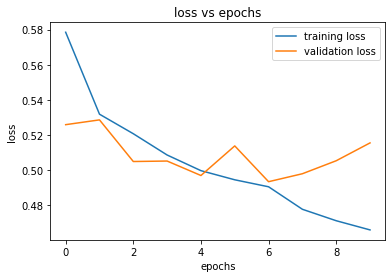

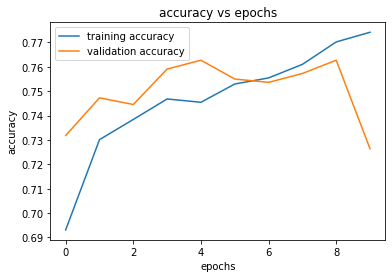

In [ ]:
plot_graph(history_lstm,'loss')
plot_graph(history_lstm,'accuracy')

In [ ]:
lstm_y_predict = model_lstm.predict(test_features_reshape)

In [ ]:
lstm_pred_list = []
for i in lstm_y_predict:
    if i > 0.4:
        lstm_pred_list.append(1)
    else:
        lstm_pred_list.append(0)

In [ ]:
lstm_submission = df_test.drop(columns = ['TEXT','LABEL'])
lstm_submission['LABEL'] = lstm_pred_list
lstm_submission.to_csv('submission_bert_lstm2.csv',index = False)

# bi-LSTM

In [ ]:
from tensorflow.keras.models import Model,Sequential
from keras.layers import Embedding,Conv1D,MaxPooling1D,LSTM,GRU,GlobalMaxPool1D,Input,Bidirectional,Dense


model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(120, dropout=0.3, recurrent_dropout=0.3,return_sequences='True'),input_shape=(None,768)))
model_bilstm.add(GlobalMaxPool1D())
model_bilstm.add(Dense(16,activation='relu'))
model_bilstm.add(Dense(1,activation='sigmoid'))
model_bilstm.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
     
model_bilstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, None, 240)         853440    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 240)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                3856      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 857,313
Trainable params: 857,313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_bilstm = model_bilstm.fit(x_train_reshape,y_train_reshape,validation_data=(x_val_reshape,y_val_reshape),epochs = 10)

Epoch 1/10
275/275 [==============================] - 4s 7ms/step - loss: 0.6037 - accuracy: 0.6667 - val_loss: 0.5190 - val_accuracy: 0.7400
Epoch 2/10
275/275 [==============================] - 1s 5ms/step - loss: 0.5293 - accuracy: 0.7325 - val_loss: 0.5102 - val_accuracy: 0.7409
Epoch 3/10
275/275 [==============================] - 1s 5ms/step - loss: 0.5169 - accuracy: 0.7428 - val_loss: 0.5049 - val_accuracy: 0.7614
Epoch 4/10
275/275 [==============================] - 1s 5ms/step - loss: 0.5071 - accuracy: 0.7464 - val_loss: 0.5070 - val_accuracy: 0.7455
Epoch 5/10
275/275 [==============================] - 1s 5ms/step - loss: 0.4952 - accuracy: 0.7557 - val_loss: 0.5062 - val_accuracy: 0.7468
Epoch 6/10
275/275 [==============================] - 1s 5ms/step - loss: 0.4859 - accuracy: 0.7638 - val_loss: 0.5117 - val_accuracy: 0.7623
Epoch 7/10
275/275 [==============================] - 1s 5ms/step - loss: 0.4680 - accuracy: 0.7731 - val_loss: 0.5054 - val_accuracy: 0.7464
Epoch 

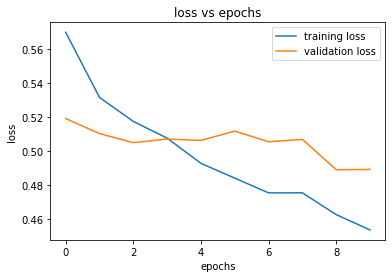

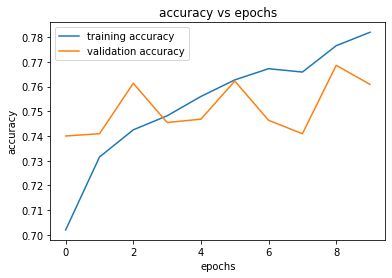

In [ ]:
plot_graph(history_bilstm,'loss')
plot_graph(history_bilstm,'accuracy')

In [ ]:
model_bilstm_y_predict = model_bilstm.predict(test_features_reshape)

In [ ]:
model_bilstm_pred_list = []
for i in model_bilstm_y_predict:
    if i > 0.4:
        model_bilstm_pred_list.append(1)
    else:
        model_bilstm_pred_list.append(0)

In [ ]:
model_bilstm_submission = df_test.drop(columns = ['TEXT','LABEL'])
model_bilstm_submission['LABEL'] = model_bilstm_pred_list
model_bilstm_submission[0:10]
model_bilstm_submission.to_csv('submission_bert_bi-LSTM2.csv', index=False)

# GRU

In [ ]:
from tensorflow.keras.models import Model,Sequential
from keras.layers import Embedding,Conv1D,MaxPooling1D,LSTM,GRU,GlobalMaxPool1D,Input,Bidirectional,Dense,BatchNormalization

model_gru = Sequential()

model_gru.add(GRU(units=120,dropout=0.3,recurrent_dropout=0.3,return_sequences=True,input_shape=(None,768)))
#model_gru.add(BatchNormalization())
#model_gru.add(GRU(128,dropout=0.3,recurrent_dropout=0.3,return_sequences=True))
#model_gru.add(BatchNormalization())
model_gru.add(GlobalMaxPool1D())
model_gru.add(Dense(16,activation='relu'))
model_gru.add(Dense(1, activation='sigmoid'))
model_gru.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 120)         320400    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 120)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1936      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 322,353
Trainable params: 322,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_gru = model_gru.fit(x_train_reshape,y_train_reshape,validation_data=(x_val_reshape,y_val_reshape),epochs = 10)

Epoch 1/10
275/275 [==============================] - 3s 5ms/step - loss: 0.6148 - accuracy: 0.6494 - val_loss: 0.5229 - val_accuracy: 0.7336
Epoch 2/10
275/275 [==============================] - 1s 4ms/step - loss: 0.5258 - accuracy: 0.7320 - val_loss: 0.5415 - val_accuracy: 0.7005
Epoch 3/10
275/275 [==============================] - 1s 4ms/step - loss: 0.5334 - accuracy: 0.7339 - val_loss: 0.5063 - val_accuracy: 0.7577
Epoch 4/10
275/275 [==============================] - 1s 4ms/step - loss: 0.5171 - accuracy: 0.7387 - val_loss: 0.5066 - val_accuracy: 0.7564
Epoch 5/10
275/275 [==============================] - 1s 4ms/step - loss: 0.5061 - accuracy: 0.7478 - val_loss: 0.4990 - val_accuracy: 0.7627
Epoch 6/10
275/275 [==============================] - 1s 4ms/step - loss: 0.4938 - accuracy: 0.7555 - val_loss: 0.5005 - val_accuracy: 0.7573
Epoch 7/10
275/275 [==============================] - 1s 4ms/step - loss: 0.4997 - accuracy: 0.7495 - val_loss: 0.4993 - val_accuracy: 0.7595
Epoch 

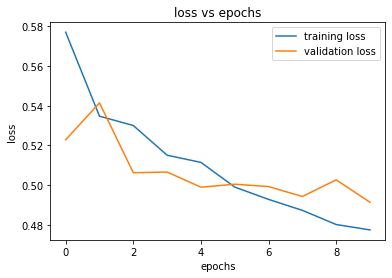

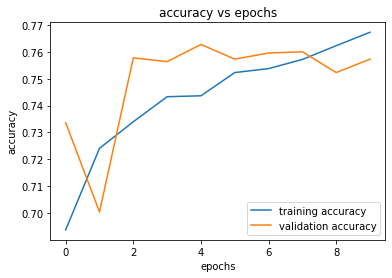

In [ ]:
plot_graph(history_gru,'loss')
plot_graph(history_gru,'accuracy')

In [ ]:
gru_y_predict = model_gru.predict(test_features_reshape)

In [ ]:
gru_pred_list = []
for i in gru_y_predict:
    if i > 0.4:
        gru_pred_list.append(1)
    else:
        gru_pred_list.append(0)

In [ ]:
gru_submission = df_test.drop(columns = ['TEXT','LABEL'])
gru_submission['LABEL'] = gru_pred_list
gru_submission.to_csv('submission_bert_gru2.csv',index = False)

# DNN

In [ ]:
from keras.layers import Dropout
model_dnn = Sequential()
model_dnn.add(Dense(units=300, activation='relu', input_shape=(x_train.shape[1],)))
model_dnn.add(Dropout(0.3))
model.add(BatchNormalization())
model_dnn.add(Dense(units=300, activation='relu'))
model_dnn.add(Dropout(0.2))
model.add(BatchNormalization())
model_dnn.add(Dense(units=16, activation='relu'))
model_dnn.add(Dense(1,activation='sigmoid'))
model_dnn.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model_dnn.summary()



NameError: ignored

In [ ]:
history_dnn = model_dnn.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=15)

Epoch 1/15
275/275 [==============================] - 2s 5ms/step - loss: 0.6446 - accuracy: 0.6171 - val_loss: 0.5229 - val_accuracy: 0.7414
Epoch 2/15
275/275 [==============================] - 1s 4ms/step - loss: 0.5406 - accuracy: 0.7276 - val_loss: 0.5154 - val_accuracy: 0.7418
Epoch 3/15
275/275 [==============================] - 1s 4ms/step - loss: 0.5133 - accuracy: 0.7414 - val_loss: 0.5187 - val_accuracy: 0.7414
Epoch 4/15
275/275 [==============================] - 1s 4ms/step - loss: 0.5034 - accuracy: 0.7525 - val_loss: 0.5053 - val_accuracy: 0.7432
Epoch 5/15
275/275 [==============================] - 1s 5ms/step - loss: 0.4983 - accuracy: 0.7501 - val_loss: 0.4989 - val_accuracy: 0.7564
Epoch 6/15
275/275 [==============================] - 1s 5ms/step - loss: 0.4882 - accuracy: 0.7626 - val_loss: 0.5284 - val_accuracy: 0.7264
Epoch 7/15
275/275 [==============================] - 1s 5ms/step - loss: 0.4875 - accuracy: 0.7618 - val_loss: 0.5173 - val_accuracy: 0.7436
Epoch 